In [392]:
import tensorflow as tf

In [393]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

In [394]:
%load_ext google.cloud.bigquery
client = bigquery.Client()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [395]:
sql = """SELECT * from covid19_open_data.covid19_open_data where location_key=country_code"""

In [396]:
df = client.query(sql).to_dataframe()

In [397]:
# from pandas import ExcelWriter
# cur_dir = %pwd
# data_path = cur_dir + '/data'
# writer = ExcelWriter(data_path + "/" + "predictor.xlsx")
# df.to_excel(writer, sheet_name='Sheet1')
# writer.save()

In [398]:
df_US = df[df['location_key'] == 'US']

In [399]:
df_US_sim = df_US.drop(columns=['subregion1_code','subregion1_name','subregion2_code','subregion2_name','iso_3166_1_alpha_2','iso_3166_1_alpha_3',
                               'datacommons_id','openstreetmap_id','rainfall_mm','snowfall_mm','mobility_parks','mobility_residential','mobility_workplaces','wikidata_id',
                               'location_geometry','current_intensive_care_patients','current_ventilator_patients','mobility_transit_stations','mobility_retail_and_recreation',
                               'mobility_grocery_and_pharmacy','new_ventilator_patients','cumulative_hospitalized_patients','cumulative_intensive_care_patients',
                               'cumulative_ventilator_patients','current_hospitalized_patients'])

# Visualizations

In [400]:
# pip install plotly

In [401]:
import plotly  
import plotly.graph_objs as go
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [402]:
df_US_sim['daily_change'] = df_US_sim.new_confirmed.pct_change()
round(df_US_sim['daily_change'], 2).quantile(0.05)

-0.31

In [403]:
# print(test_lst)
test_lst = list(df_US_sim['daily_change'])
new_test_lst = []
for items in test_lst:
    if items == float('nan') or items == float('inf'):
        new_test_lst.append(0.0)
    else:
        new_test_lst.append(items)
df_US_sim['daily_change'] = new_test_lst
df_US_sim['daily_change'] = df_US_sim['daily_change'].fillna(0.0)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<Figure size 432x288 with 0 Axes>

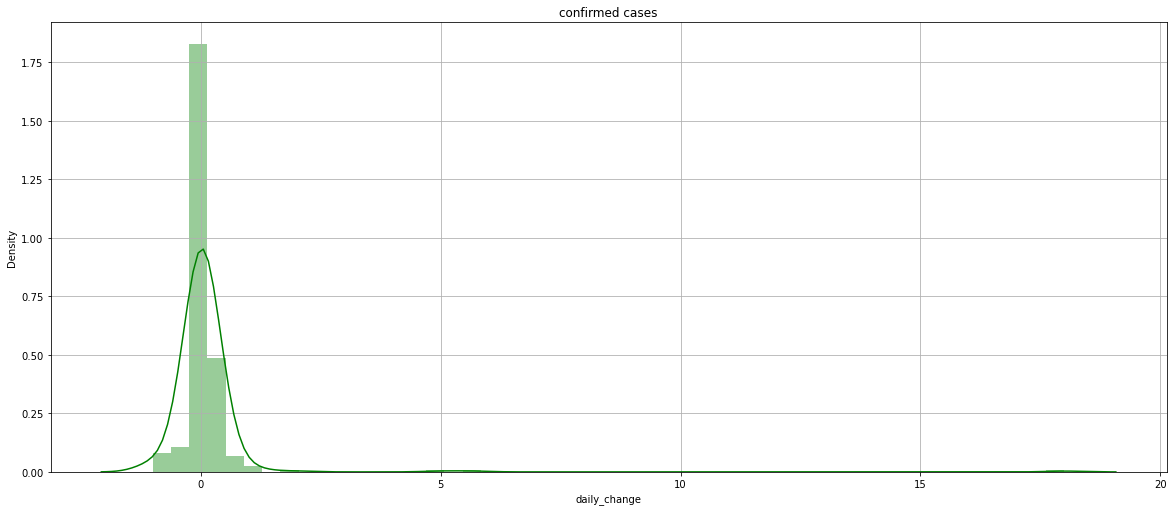

In [404]:
sns.despine(left=True)

#plot a simple histogram with binsize determined automatically
# plt.Figure(figsize=(20,10))
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(df_US_sim['daily_change'], color="green")
plt.title('confirmed cases')
plt.grid(True)
plt.show()

### With 95% confidence, the daily increase in Covid cases will not exceed 31% of the previous day's confirmed cases

### If we have 10,000 cases today, our one-day 31% VaR is 0.31 * 10,000 = 3100

In [405]:
df_US_sim_ind = df_US_sim.set_index('date')

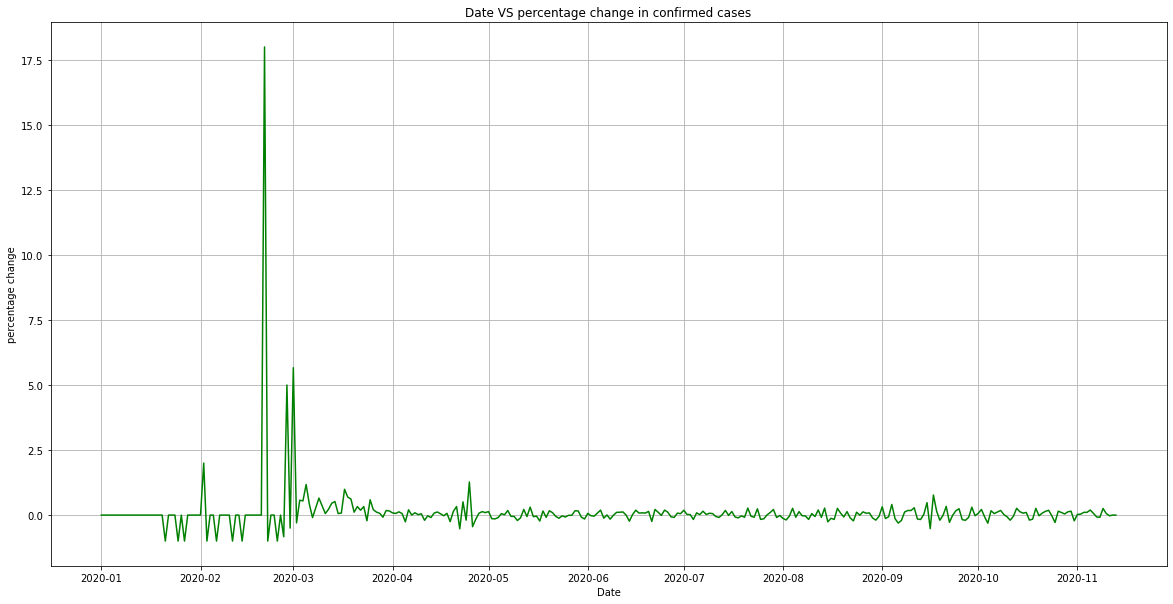

In [406]:
df_US_sim_ind['daily_change'].plot(figsize = (20, 10), color="green", grid = True)
plt.xlabel("Date")
plt.ylabel("percentage change")
plt.title("Date VS percentage change in confirmed cases")
plt.show()

# Feature Engineering
## Adding Weeks, Months and Year Columns

In [407]:
df_US_sim_ind.index = pd.to_datetime(df_US_sim_ind.index, errors='coerce')

In [408]:
# df_US_sim_ind

In [409]:
df_US_sim_ind['day_of_week'] = df_US_sim_ind.index.dayofweek
df_US_sim_ind['day_of_month'] = df_US_sim_ind.index.day
df_US_sim_ind['quarter'] = df_US_sim_ind.index.quarter
df_US_sim_ind['month'] = df_US_sim_ind.index.month
df_US_sim_ind['year'] = df_US_sim_ind.index.year
# df_US_sim_ind

## Adding Summary of the values at previous Time Steps

In [410]:
width = 3
shifted = df_US_sim_ind['new_confirmed'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df_US_sim_ind['min'] = roll_window.min()
df_US_sim_ind['mean'] = roll_window.mean()
df_US_sim_ind['max'] = roll_window.max()
# df_US_sim_ind

In [411]:
df_pred = df_US_sim_ind.copy()
# df_pred

In [412]:
# df_pred = df_US_sim_ind.copy()
# variable for predicting 'n' days out into the future
n = int(30)
future_pred = n
df_pred = df_pred[:-2]
# Create another column (the target/ dependent variable) shifted 'n' units up
df_pred['prediction'] = df_pred['cumulative_confirmed'].shift(-future_pred)
# df_pred['prediction'] = df_pred['new_confirmed']
# df_pred = df_pred.dropna(inplace=True)
# df_pred.head()

In [413]:
df_pred = df_pred.drop(columns=['cumulative_recovered', 'new_recovered'])

In [414]:
df_pred = df_pred.fillna(0)
# df_pred[300:]

In [415]:
df_pred.columns

Index(['location_key', 'country_code', 'country_name', 'aggregation_level',
       'new_confirmed', 'new_deceased', 'new_tested', 'cumulative_confirmed',
       'cumulative_deceased', 'cumulative_tested', 'new_hospitalized_patients',
       'new_intensive_care_patients', 'latitude', 'longitude',
       'average_temperature_celsius', 'minimum_temperature_celsius',
       'maximum_temperature_celsius', 'daily_change', 'day_of_week',
       'day_of_month', 'quarter', 'month', 'year', 'min', 'mean', 'max',
       'prediction'],
      dtype='object')

In [416]:
X = np.array(df_pred.drop(columns = ['location_key','country_code','country_name','aggregation_level'
                                    ,'new_deceased','cumulative_confirmed','cumulative_deceased','cumulative_tested'
                                    ,'latitude', 'longitude','minimum_temperature_celsius',
                                   'maximum_temperature_celsius', 'daily_change', 'day_of_week',
                                   'day_of_month', 'quarter', 'month', 'year', 'min', 'mean', 'max',
                                   'prediction'],axis=1))

In [417]:
X.shape

(316, 5)

In [418]:
X_forecast = X[-future_pred:]
X = X[:-future_pred]
y = np.array(df_pred['prediction'])
y = y[:-future_pred]

In [419]:
X.shape

(286, 5)

In [420]:
from sklearn.model_selection   import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Time series length: ",len(X_train))
print("Number of time series: ", len(X_train[0,1:]))

Time series length:  200
Number of time series:  4


# Time-Series Cross Validation (tscv)

In [421]:
# pip install tscv

In [422]:
import tscv as cv

In [423]:
cv = cv.GapKFold(n_splits=2, gap_before=1, gap_after=1)
for train, test in cv.split(range(10)):
    print("train: ", X_train, "test: ", X_test)

train:  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -5.8024690e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   2.5802470e+00]
 [ 4.8085000e+04  5.6214000e+05  0.0000000e+00  0.0000000e+00
   2.4105556e+01]
 [ 2.2223000e+04  4.1032400e+05  0.0000000e+00  0.0000000e+00
   2.8216049e+01]
 [ 2.5023000e+04  1.5864100e+05  0.0000000e+00  0.0000000e+00
  -7.9012300e-01]
 [ 5.2804000e+04  9.5965700e+05  0.0000000e+00  0.0000000e+00
   2.0961111e+01]
 [ 3.9852000e+04  7.2817800e+05  0.0000000e+00  0.0000000e+00
   2.0533333e+01]
 [ 1.9064000e+04  4.5706900e+05  0.0000000e+00  0.0000000e+00
   1.6048611e+01]
 [ 7.4985000e+04  1.0253020e+06  0.0000000e+00  0.0000000e+00
   2.5405556e+01]
 [ 4.9093000e+04  7.0970800e+05  0.0000000e+00  0.0000000e+00
   2.5123457e+01]
 [ 3.5056000e+04  8.6778100e+05  0.0000000e+00  0.0000000e+00
   2.3450000e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -9.1358000e-01]
 [ 2.6857000e+04  2.2322800e+05 

In [424]:
# pip install xgboost

In [425]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [426]:
reg = xgb.XGBRegressor(objective = 'reg:squarederror', n_jobs=-1)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [427]:
confidence = reg.score(X_test, y_test)
print("Confidence %: ", round(confidence*100,2))
print('\n')
prediction = reg.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
prediction = prediction
print(prediction)
print('\n')

rmse = np.sqrt(mean_squared_error(y_test[:future_pred], prediction[:future_pred]))
print('Test RMSE: %.3f' % rmse)
print('\n')
model_scores.append(rmse)

Confidence %:  86.2


Expected confirmed cases for next 30 days
[9122782.  8455884.  8512590.  7033029.  8019230.  7798270.5 8335140.5
 8427364.  8510046.  8495816.  7027824.  7523173.5 6885118.5 8281716.5
 8610404.  8209589.5 8211513.5 8041543.5 6643084.  6784101.5 8041543.5
 8217967.  8214098.  8039320.  6761297.5 6612463.  2766134.2 1195160.
 1195160.  1195160. ]


Test RMSE: 5634903.530




In [428]:
from sklearn import linear_model as lm
reg1 = lm.LinearRegression()
reg1.fit(X_train, y_train)

LinearRegression()

In [429]:
confidence1 = reg1.score(X_test, y_test)
print("Confidence %: ", round(confidence1*100,2))
print('\n')
prediction1 = reg1.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
print(prediction1)
print('\n')

rmse1 = np.sqrt(mean_squared_error(y_test[:future_pred], prediction1[:future_pred]))
print('Test RMSE: %.3f' % rmse1)
print('\n')
model_scores.append(rmse)

Confidence %:  84.43


Expected confirmed cases for next 30 days
[ 8060593.95250287  8530134.11609347  9008019.7767009   7783523.86508648
  5543082.86728802  6075352.88575622  8454619.06647198  9699238.66298562
 10194961.94545668  9976106.1274665   8354363.1255394   6074509.35918401
  6748362.7714498   9003586.64634292  9883280.07853197  9975786.98211625
 10326242.75796556  8773097.69941264  6659625.29794915  7169261.08420911
  8603717.23442653  9808758.95956706  9843932.79031435  9236383.15244364
  8349170.94148345  5991130.96748454  4057869.61409824  1493799.6746144
  1576035.59093257  1537063.64348835]


Test RMSE: 6084833.484




In [430]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, random_state=0)

In [431]:
confidence3 = regr.score(X_test, y_test)
print("Confidence %: ", round(confidence3*100,2))
print('\n')
prediction3 = regr.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
print(prediction3)
print('\n')

rmse3 = np.sqrt(mean_squared_error(y_test[:future_pred], prediction3[:future_pred]))
print('Test RMSE: %.3f' % rmse3)
print('\n')
model_scores.append(rmse)

Confidence %:  87.34


Expected confirmed cases for next 30 days
[8712297.54289572 8892000.62639155 8734477.49027348 7734944.74804729
 8101317.44738244 8019770.02390146 8874463.87667727 8940485.89235692
 8734477.49027348 8734477.49027348 7998834.9154273  7648287.30853936
 7834875.98840058 8686743.4973211  8734477.49027348 8734477.49027348
 8734477.49027348 8668455.47459382 7628211.60553936 7618629.34053935
 8668455.47459382 8734477.49027348 8734477.49027348 8668455.47459382
 7635787.42553936 7733050.38392428 2539465.40160586  729222.76219937
  729222.76219937  729222.76219937]


Test RMSE: 6029384.753




In [432]:
y_test_list = []
for i in y_test[:future_pred]:
    y_test_list.append(float(i))
print(y_test_list)

[2347022.0, 6150655.0, 59.0, 2280912.0, 2312302.0, 6764962.0, 2839542.0, 4034102.0, 15.0, 55231.0, 8493669.0, 9971651.0, 11.0, 69194.0, 6519979.0, 8106752.0, 125.0, 1312.0, 143025.0, 7.0, 7549794.0, 1133069.0, 10110552.0, 4290263.0, 6804814.0, 103.0, 2114026.0, 10401132.0, 5702611.0, 4998017.0]


In [433]:
df_US_sim_ARM = df_US_sim[['date','cumulative_confirmed']]

In [434]:
df_US_sim_ARM = df_US_sim_ARM[:-2]
# df_US_sim_ARM

## Holts

In [435]:
# pip install fbprophet

In [436]:
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures

In [437]:
valid_set = df_US_sim_ARM[-30:]
train_set = df_US_sim_ARM[:-30]
begin_date = '2020-11-09'
df_date = pd.DataFrame({'cumulative_confirmed':0, 
                      'date':pd.date_range(begin_date, periods=90)})
test_set = valid_set.append(df_date, ignore_index=True)
test_set['date'] = pd.to_datetime(test_set['date'] ,errors = 'coerce',format = '%Y-%m-%d')
test_set = test_set.set_index('date')

In [438]:
# model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
# valid=datewise.iloc[int(datewise.shape[0]*0.95):]
model_train = train_set.set_index('date')  # only training set without last 30 rows
valid = valid_set.set_index('date') # only validation set with only last 30 rows
y_pred=test_set.copy() # validation set + test set with last 30 rows + additional 90 rows/dates

In [439]:
holt=Holt(np.asarray(model_train["cumulative_confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False) 

In [440]:
model_scores = []
y_pred["Holt"]=holt.forecast(len(test_set))
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt"][:valid.shape[0]-1])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt"][:valid.shape[0]-1])))

Root Mean Square Error Holt's Linear Model:  413298.51860575617


In [441]:
# y_pred['Holt'] = y_pred['Holt'].astype(int)

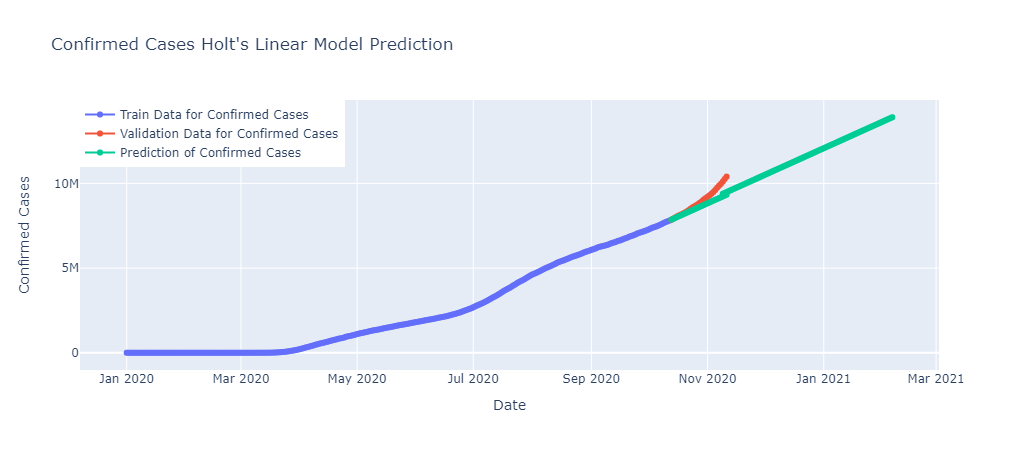

In [442]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Holt's Winter Model for Daily Time Series

In [443]:
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].astype(int)
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].abs()
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].replace(0,1)

In [445]:
es=ExponentialSmoothing(np.asarray(model_train['cumulative_confirmed_winter']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [446]:
y_pred["Holt's Winter Model"]=es.forecast(len(test_set))
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt's Winter Model"][:valid.shape[0]-1])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt's Winter Model"][:valid.shape[0]-1])))

Root Mean Square Error for Holt's Winter Model:  482628.351303854


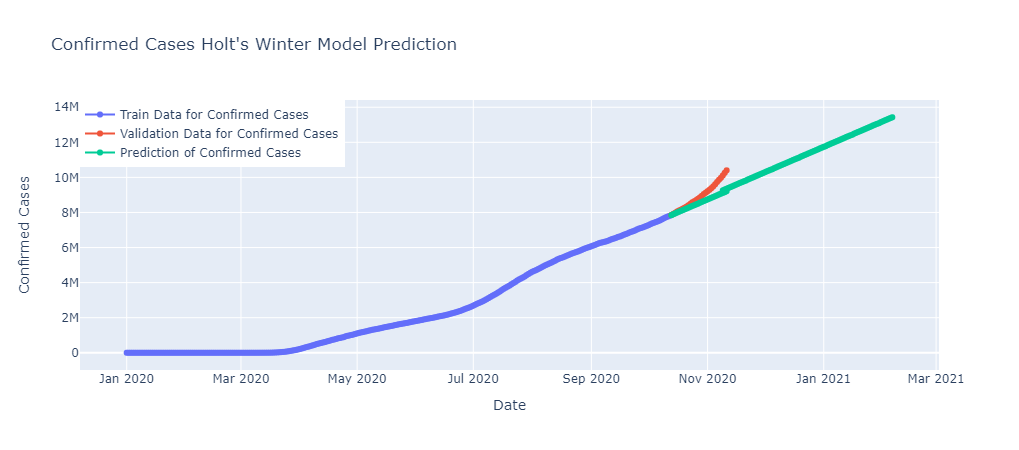

In [447]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed_winter"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["Holt's Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [448]:
y_pred["Holt's Winter Model"] = y_pred["Holt's Winter Model"].astype(int)
# y_pred

,cumulative_confirmed,Holt,Holt's Winter Model
date,,,
2020-10-13,7856714.0,7.860903e+06,7844569
2020-10-14,7916100.0,7.911711e+06,7900410
2020-10-15,7979885.0,7.962519e+06,7946445
2020-10-16,8050141.0,8.013328e+06,7994804
2020-10-17,8106752.0,8.064136e+06,8039140
...,...,...,...
2021-02-02,0.0,1.370384e+07,13245499
2021-02-03,0.0,1.375465e+07,13288172
2021-02-04,0.0,1.380546e+07,13336924


## AR Model (using AUTO ARIMA)

In [449]:
# conda create -n pmdarima --yes python=3.5 scipy numpy scikit-learn pandas statsmodels

In [450]:
# conda install --yes -c anaconda pyramid

In [451]:
# pip install pmdarima

In [452]:
from pmdarima.arima import auto_arima

In [453]:
model_ar= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5745.390, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5729.040, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5720.724, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5707.409, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=5702.118, Time=0.12 sec
Total fit time: 0.284 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True)

In [454]:
prediction_ar=model_ar.predict(len(test_set))
y_pred["AR Model Prediction"]=prediction_ar

In [455]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["AR Model Prediction"][:valid.shape[0]-1])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["AR Model Prediction"][:valid.shape[0]-1])))

Root Mean Square Error for AR Model:  438749.2487248587


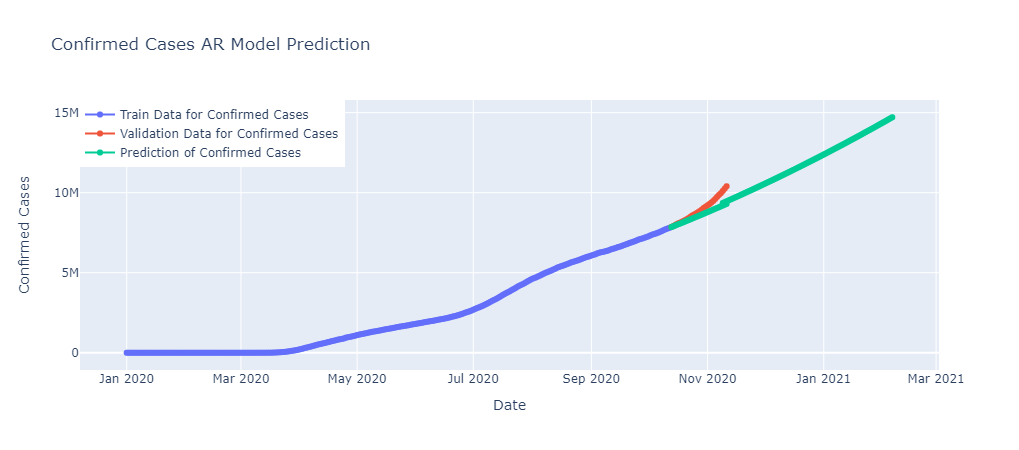

In [456]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### MA Model (using AUTO ARIMA)

In [457]:
model_ma= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5745.390, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5709.289, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5700.091, Time=0.08 sec
Total fit time: 0.144 seconds


ARIMA(order=(0, 2, 2), scoring_args={}, suppress_warnings=True)

In [458]:
prediction_ma=model_ma.predict(len(test_set))
y_pred["MA Model Prediction"]=prediction_ma

In [460]:
prediction_ma.shape

(120,)

In [461]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_ma[:valid.shape[0]-1])))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_ma[:valid.shape[0]-1])))

Root Mean Square Error for MA Model:  386763.5690969294


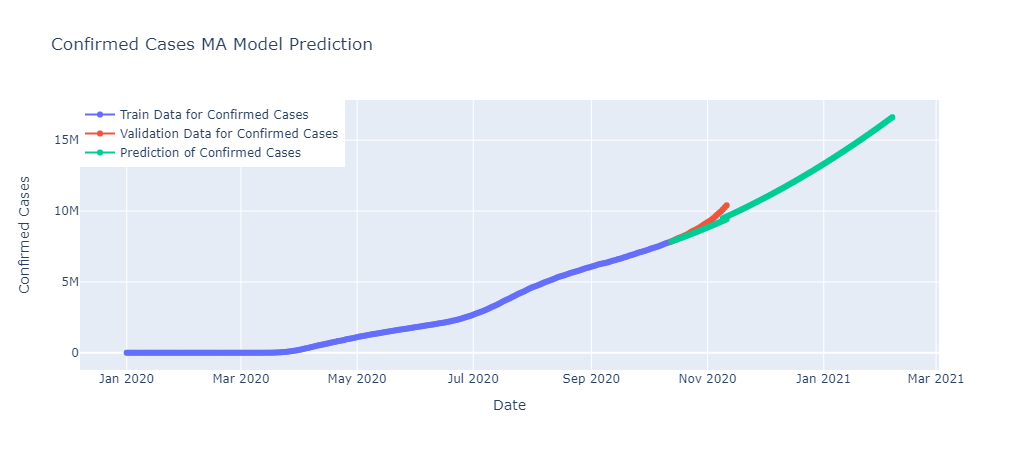

In [462]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### ARIMA Model (using AUTOARIMA)

In [463]:
model_arima= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5745.390, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5709.289, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5700.091, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=5703.196, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5729.040, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5700.500, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=5703.508, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=5678.492, Time=0.92 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5720.724, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=5697.612, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5705.514, Time=0.40 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=5646.723, Time=0.87 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5707.409, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=5690.827, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=5696.536, Time=0.28 sec
Total fit 

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [464]:
prediction_arima=model_arima.predict(len(test_set))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [465]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_arima[:valid.shape[0]-1])))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_arima[:valid.shape[0]-1])))

Root Mean Square Error for ARIMA Model:  315631.8955534377


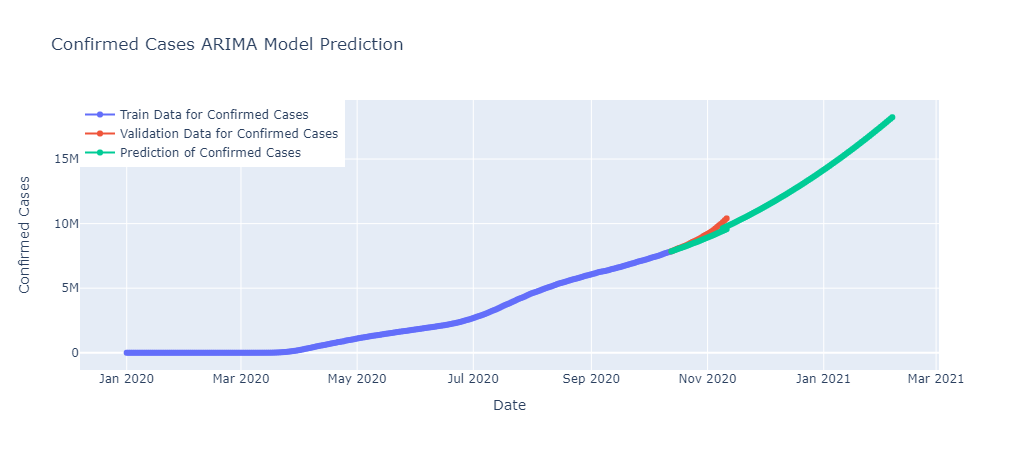

In [466]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### SARIMA Model (using AUTO ARIMA)

In [467]:
model_sarima= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_sarima.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5745.390, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5709.289, Time=0.05 sec


/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:60: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5700.091, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5729.040, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5700.500, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=5703.508, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5720.724, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=5697.612, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5705.514, Time=0.43 sec
Total fit time: 1.107 seconds


ARIMA(order=(2, 2, 1), scoring_args={}, suppress_warnings=True)

In [468]:
prediction_sarima=model_sarima.predict(len(test_set))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [469]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["SARIMA Model Prediction"][:valid.shape[0]-1])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["SARIMA Model Prediction"][:valid.shape[0]-1])))

Root Mean Square Error for SARIMA Model:  401102.9019081623


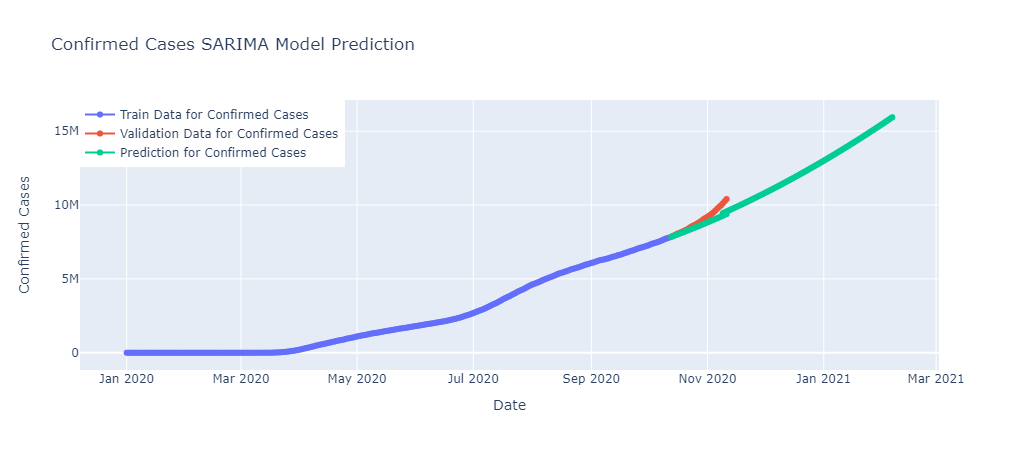

In [470]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Facebook's Prophet Model for forecasting

In [471]:
df_US_sim_FB = df_US_sim_ARM.set_index('date')

In [472]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(df_US_sim_FB.index),list(df_US_sim_FB["cumulative_confirmed"])),columns=['ds','y'])

In [473]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [474]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [475]:
confirmed_forecast=prophet_c.predict(forecast_c)

In [476]:
model_scores.append(np.sqrt(mean_squared_error(df_US_sim_FB["cumulative_confirmed"],confirmed_forecast['yhat'].head(df_US_sim_FB.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(df_US_sim_FB["cumulative_confirmed"],confirmed_forecast['yhat'].head(df_US_sim_FB.shape[0]))))

Root Mean Squared Error for Prophet Model:  101404.34150202833


Figure(720x432)


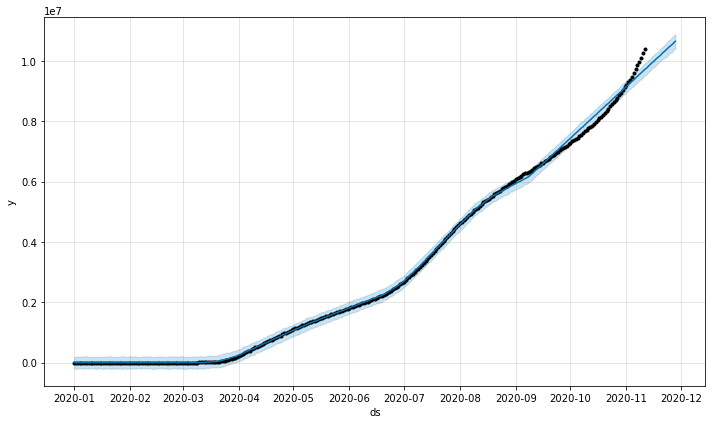

In [477]:
print(prophet_c.plot(confirmed_forecast))

In [478]:
model_scores

[413298.51860575617,
 482628.351303854,
 438749.2487248587,
 386763.5690969294,
 315631.8955534377,
 401102.9019081623,
 101404.34150202833]

In [479]:
model_names=["XGBoost","Linear Regression","Random Forest Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
6,Moving Average Model (MA),101404.341502
4,Holt's Winter Model,315631.895553
3,Holt's Linear,386763.569097
5,Auto Regressive Model (AR),401102.901908
0,XGBoost,413298.518606
2,Random Forest Regressor,438749.248725
1,Linear Regression,482628.351304


In [480]:
y_pred = y_pred[['cumulative_confirmed','AR Model Prediction','MA Model Prediction','ARIMA Model Prediction','SARIMA Model Prediction']].astype(int)

In [481]:
y_pred

,cumulative_confirmed,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
date,,,,,
2020-10-13,7856714,7851088,7850828,7850840,7851298
2020-10-14,7916100,7900631,7899102,7902855,7900317
2020-10-15,7979885,7950207,7947805,7958927,7949316
2020-10-16,8050141,7998126,7996940,8015264,7998332
2020-10-17,8106752,8045419,8046505,8068429,8047653
...,...,...,...,...,...
2021-02-02,0,14444685,16226032,17742534,15592170
2021-02-03,0,14511785,16323846,17865925,15678738
2021-02-04,0,14579054,16422090,17989024,15765638
